# Lecture 4: Composite System and interfacing with QuTiP

https://scqubits.readthedocs.io/en/v3.2/guide/hilbertspace/ipynb/hilbertspace.html

Systems of interest for quantum information processing will involve multiple qubits as well as oscillators with mutual coupling. 

The resulting Hilbert space is the tensor product of the individual constituent Hilbert spaces. 

The `HilbertSpace` class allows one to define such coupled systems, to define the interactions between them, and to contruct the overall Hamiltonian. 

From this, dressed eigenenergies and eigenstates can be extracted. 

The operator matrices and state vectors  at the `HilbertSpace` level are given as QuTiP `Qobj` instances. 

This interface to QuTiP is particularly helpful if the task at hand is the simulation of time-dependent dynamics of the coupled system, perhaps including additional drive terms.

In [1]:
import scqubits as scq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

### $H = H_\textrm{transmon1} + H_\textrm{transmon1} + H_\textrm{resonator} + \sum_{i=1,2}g_i n_i (a+a^\dagger)$

## Creating a HilbertSpace instance

The first step consists of creating the objects describing the individual building blocks of the full Hilbert space. Here, these will be the two transmons and one oscillator:

In [2]:
tmon1 = scq.Transmon(
    EJ=40.0,
    EC=0.2,
    ng=0.3,
    ncut=40,
    truncated_dim=4     
)

tmon2 = scq.Transmon(
    EJ=15.0,
    EC=0.15,
    ng=0.0,
    ncut=30,
    truncated_dim=4
)

resonator = scq.Oscillator(
    E_osc=4.5,
    truncated_dim=4  
)

### create `HilbertSpace` with GUI

In [3]:
hilbertspace = scq.HilbertSpace.create()

Output()

### create `HilbertSpace` with coding 

In [4]:
hilbertspace = scq.HilbertSpace([tmon1, tmon2, resonator])
print(hilbertspace)

HilbertSpace:  subsystems
-------------------------

Transmon------------| [Transmon_1]
                    | EJ: 40.0
                    | EC: 0.2
                    | ng: 0.3
                    | ncut: 40
                    | truncated_dim: 4
                    |
                    | dim: 81


Transmon------------| [Transmon_2]
                    | EJ: 15.0
                    | EC: 0.15
                    | ng: 0.0
                    | ncut: 30
                    | truncated_dim: 4
                    |
                    | dim: 61


Oscillator----------| [Oscillator_1]
                    | E_osc: 4.5
                    | l_osc: None
                    | truncated_dim: 4
                    |
                    | dim: 4




## Specifying interactions between subsystems

### Option 1: operator-product based interface

In [5]:
g1 = 0.1  
operator1 = tmon1.n_operator()
operator2 = resonator.creation_operator() + resonator.annihilation_operator()

hilbertspace.add_interaction(
    g=g1,
    op1=(operator1, tmon1),
    op2=(operator2, resonator)
)

(array, subsystem): a tuple with an array or sparse matrix in the first position and the subsystem in the second position

In [6]:
g2 = 0.2  
hilbertspace.add_interaction(
    g=g2,
    op1=tmon2.n_operator,
    op2=resonator.creation_operator,
    add_hc=True
)

callable: the operator as a callable function (which will automatically yield the subsystem the operator function is bound to)

Interactions with more than two operators are built by specifying op3, op4, etc.

### Option 2: string- based interface

In [7]:
hilbertspace_example = scq.HilbertSpace([tmon1, tmon2, resonator])

g3 = 0.1

hilbertspace_example.add_interaction(
    expr="g3 * cos(n) * adag",
    op1=("n", tmon1.n_operator),
    op2=("adag", resonator.creation_operator),
    add_hc=True
)

### Option 3: Qobj interface

In [8]:
# Generate a Qobj
g = 0.1
a = qt.destroy(4)
kerr = a.dag() * a.dag() * a * a
id = qt.qeye(4)
V = g * qt.tensor(id, id, kerr)

hilbertspace_example.add_interaction(qobj = V)

## Obtaining the Hamiltonian

With the interactions specified, the full Hamiltonian of the coupled system can be obtained via the method `.hamiltonian()`. This conveniently results in a `qubit.Qobj` operator:

In [9]:
dressed_hamiltonian = hilbertspace.hamiltonian()
dressed_hamiltonian

Quantum object: dims = [[4, 4, 4], [4, 4, 4]], shape = (64, 64), type = oper, isherm = True
Qobj data =
[[-4.89675306e+01  3.00000000e-02  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.00000000e-02 -4.44675306e+01  4.24264069e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.24264069e-02 -3.99675306e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -9.97661845e+00
   4.24264070e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.24264070e-02
  -5.47661845e+00  5.19615243e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   5.19615243e-02 -9.76618450e-01]]

This matrix is the representation of the Hamiltonian in the bare product basis.

The non-interacting (“bare”) Hamiltonian and the interaction Hamiltonian can be accessed similarly by using the methods `.bare_hamiltonian()` and `.interaction_hamiltonian()`.

### Obtaining the eigenspectrum via QuTiP

In [10]:
evals, evecs = hilbertspace.eigensys(evals_count=4)
print(evals)

[-48.97770317 -45.02707241 -44.36656205 -41.18438832]


In [11]:
dressed_hamiltonian = hilbertspace.hamiltonian()
dressed_hamiltonian.eigenenergies(eigvals=4)

array([-48.97770317, -45.02707241, -44.36656205, -41.18438832])

## Spectrum lookup: converting between bare and dressed indices

We can refer to eigenstates and eigenenergies of the interacting quantum systems in two ways:

- dressed indices: enumerating eigenenergies and -states as j=0,1,2,... starting from the ground state

- bare product state indices: for a Hilbert space composed of three subsystems, specify tuples of the form (l,m,n) where l, m, n denote the excitation levels of each bare subsystem.

To use lookup functions converting back and forth between these indexing schemes, first generate the spectrum lookup table via:

In [9]:
hilbertspace.generate_lookup()

In [12]:
hilbertspace.bare_index(10)

(1, 0, 1)

In [11]:
hilbertspace.dressed_index((2, 1, 0))

21

In [15]:
hilbertspace.energy_by_dressed_index(10)

-36.566941385270155

## Helper function: identity wrapping

In [13]:
scq.identity_wrap(tmon2.n_operator(), tmon2, hilbertspace.subsystem_list)

Quantum object: dims = [[4, 4, 4], [4, 4, 4]], shape = (64, 64), type = oper, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

## Helper function: subsystem operator in dressed basis

Oftentimes for qutip simulations, the most natural basis to use is the dressed basis of the full system. 

This way, any transitions between basis states are the result of additional (usually time-dependent) drives. 

These drives are often given in terms of an operator of one of the subsystems. We would like to transform that operator into the dressed basis.

In [14]:
hilbertspace.op_in_dressed_eigenbasis(op=tmon1.n_operator)

Quantum object: dims = [[4, 4, 4], [4, 4, 4]], shape = (64, 64), type = oper, isherm = True
Qobj data =
[[ 3.00848255e-01  3.94988892e-02 -8.51789422e-02 ...  9.21701664e-11
   7.38031482e-11 -1.48511924e-10]
 [ 3.94988892e-02  3.00848175e-01  9.55399274e-08 ...  1.14676365e-08
   1.31056967e-08 -2.16270173e-10]
 [-8.51789422e-02  9.55399273e-08  3.00848062e-01 ... -2.19795961e-08
  -2.87402589e-08  2.13684822e-11]
 ...
 [ 9.21701664e-11  1.14676365e-08 -2.19795961e-08 ...  3.01845306e-01
   6.18505106e-03  4.60901874e-01]
 [ 7.38031482e-11  1.31056967e-08 -2.87402589e-08 ...  6.18505106e-03
   3.02528544e-01 -2.48191443e-01]
 [-1.48511924e-10 -2.16270173e-10  2.13684822e-11 ...  4.60901874e-01
  -2.48191443e-01  3.08183200e-01]]

In [18]:
hilbertspace.op_in_dressed_eigenbasis(op=(tmon1.n_operator(), tmon1), op_in_bare_eigenbasis=False)

Quantum object: dims = [[4, 4, 4], [4, 4, 4]], shape = (64, 64), type = oper, isherm = True
Qobj data =
[[ 3.00848255e-01  3.94988892e-02 -8.51789422e-02 ...  9.21701664e-11
   7.38031482e-11 -1.48511924e-10]
 [ 3.94988892e-02  3.00848175e-01  9.55399274e-08 ...  1.14676365e-08
   1.31056967e-08 -2.16270173e-10]
 [-8.51789422e-02  9.55399273e-08  3.00848062e-01 ... -2.19795961e-08
  -2.87402589e-08  2.13684822e-11]
 ...
 [ 9.21701664e-11  1.14676365e-08 -2.19795961e-08 ...  3.01845306e-01
   6.18505106e-03  4.60901874e-01]
 [ 7.38031482e-11  1.31056967e-08 -2.87402589e-08 ...  6.18505106e-03
   3.02528544e-01 -2.48191443e-01]
 [-1.48511924e-10 -2.16270173e-10  2.13684822e-11 ...  4.60901874e-01
  -2.48191443e-01  3.08183200e-01]]

In [19]:
n_1_bare_eigenbasis = tmon1.n_operator(energy_esys=True)
hilbertspace.op_in_dressed_eigenbasis(op=(n_1_bare_eigenbasis, tmon1), op_in_bare_eigenbasis=True)

Quantum object: dims = [[4, 4, 4], [4, 4, 4]], shape = (64, 64), type = oper, isherm = True
Qobj data =
[[ 3.00848255e-01  3.94988892e-02 -8.51789422e-02 ...  9.21701664e-11
   7.38031482e-11 -1.48511924e-10]
 [ 3.94988892e-02  3.00848175e-01  9.55399274e-08 ...  1.14676365e-08
   1.31056967e-08 -2.16270173e-10]
 [-8.51789422e-02  9.55399273e-08  3.00848062e-01 ... -2.19795961e-08
  -2.87402589e-08  2.13684822e-11]
 ...
 [ 9.21701664e-11  1.14676365e-08 -2.19795961e-08 ...  3.01845306e-01
   6.18505106e-03  4.60901874e-01]
 [ 7.38031482e-11  1.31056967e-08 -2.87402589e-08 ...  6.18505106e-03
   3.02528544e-01 -2.48191443e-01]
 [-1.48511924e-10 -2.16270173e-10  2.13684822e-11 ...  4.60901874e-01
  -2.48191443e-01  3.08183200e-01]]

## Example: Rabi driving via resonator

In [16]:
tmon = scq.Transmon(EJ=25.8, EC=0.185, ng=0.0, ncut=20)

res = scq.Oscillator(
    E_osc=7.5,
    truncated_dim=6
)

hspace = scq.HilbertSpace([tmon, res])

In [17]:
hspace.add_interaction(
    g=0.1,
    op1=tmon.n_operator,
    op2=res.annihilation_operator,
    add_hc=True
)

### option 1: working in bare basis

In [22]:
dressed_evals, dressed_evecs = hspace.eigensys()
hspace.generate_lookup()

H_sys = hspace.hamiltonian()
a_r = scq.identity_wrap(res.annihilation_operator(), res, hspace.subsystem_list)
drive_op = a_r + a_r.dag()


ham_list = [H_sys * 2*np.pi,
            [drive_op, 'A * sin(pi * t / tau_p)**2 * cos(omega_d * t)']]

In [23]:
zero_state = dressed_evecs[hspace.dressed_index((0,0))]
one_state = dressed_evecs[hspace.dressed_index((1,0))]
observables = [zero_state * zero_state.dag(), one_state * one_state.dag()]

In [24]:
rotation_angle = np.pi
A = 6
tau_p = np.pi/(A*abs((zero_state.dag() * drive_op * one_state).tr())/2)

E_01 = dressed_evals[hspace.dressed_index((1,0))] - dressed_evals[hspace.dressed_index((0,0))]

args = {
    'A': A,                        # amplitude in GHz
    'tau_p': tau_p,                # pulse duration in ns
    'omega_d': 2 * np.pi * E_01    # ang. drive frequency
    }

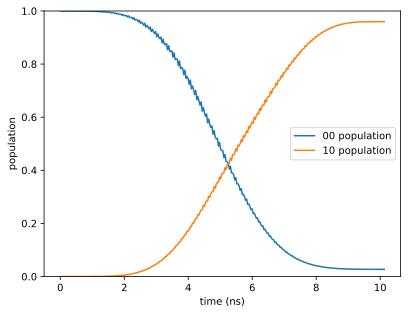

In [25]:
times = np.linspace(0, tau_p, 300)

options = qt.Options(rtol=1e-10, atol=1e-10, nsteps = 10000000, store_states = True, store_final_state = True)

result = qt.sesolve(ham_list, zero_state, times, e_ops = observables, options = options, args = args)

plt.plot(times, result.expect[0], label='00 population')
plt.plot(times, result.expect[1], label = '10 population')
plt.ylim(0,1)
plt.legend()
plt.xlabel('time (ns)')
plt.ylabel('population')
plt.show()

### option 2: working in dressed basis

In [19]:
dressed_evals, dressed_evecs = hspace.eigensys(evals_count = 36)
hspace.generate_lookup()

H_sys = qt.Qobj(np.diag(dressed_evals))

a_r = hspace.op_in_dressed_eigenbasis(op=res.annihilation_operator)

In [20]:
a_r

Quantum object: dims = [[6, 6], [6, 6]], shape = (36, 36), type = oper, isherm = False
Qobj data =
[[ 0.00000000e+00 -9.28925814e-02  9.95732020e-01 ... -2.10503292e-12
   2.15176795e-11  0.00000000e+00]
 [-1.05238143e-02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.39244086e-10]
 [-7.80657254e-04  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -1.17514985e-09]
 ...
 [ 1.62061035e-12  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  2.16551410e+00]
 [-1.67644413e-11  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  5.54739354e-01]
 [ 0.00000000e+00 -1.08012274e-10  9.05364395e-10 ... -2.49336711e-02
   1.13830600e-01  0.00000000e+00]]

In [21]:
a_r.dims = [[len(dressed_evals)], [len(dressed_evals)]]
a_r

Quantum object: dims = [[36], [36]], shape = (36, 36), type = oper, isherm = False
Qobj data =
[[ 0.00000000e+00 -9.28925814e-02  9.95732020e-01 ... -2.10503292e-12
   2.15176795e-11  0.00000000e+00]
 [-1.05238143e-02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.39244086e-10]
 [-7.80657254e-04  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -1.17514985e-09]
 ...
 [ 1.62061035e-12  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  2.16551410e+00]
 [-1.67644413e-11  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  5.54739354e-01]
 [ 0.00000000e+00 -1.08012274e-10  9.05364395e-10 ... -2.49336711e-02
   1.13830600e-01  0.00000000e+00]]

In [18]:
dressed_evals, dressed_evecs = hspace.eigensys(evals_count = 36)
hspace.generate_lookup()

H_sys = qt.Qobj(np.diag(dressed_evals))

a_r = hspace.op_in_dressed_eigenbasis(op=res.annihilation_operator)
a_r.dims = [[len(dressed_evals)], [len(dressed_evals)]]
drive_op = a_r + a_r.dag()

ham_list = [
     H_sys * 2*np.pi,
     [drive_op, 'A * sin(pi * t / tau_p)**2 * cos(omega_d * t)']
    ]

In [27]:
zero_state = qt.basis(len(dressed_evals), hspace.dressed_index((0,0)))
one_state = qt.basis(len(dressed_evals), hspace.dressed_index((1,0)))
observables = [zero_state * zero_state.dag(), one_state * one_state.dag()]

In [28]:
rotation_angle = np.pi
A = 6

tau_p = np.pi/(A*abs((zero_state.dag() * drive_op * one_state).tr())/2)

E_01 = dressed_evals[hspace.dressed_index((1,0))] - dressed_evals[hspace.dressed_index((0,0))]

args = {
    'A': A,                        # amplitude in GHz
    'tau_p': tau_p,                # pulse duration in ns
    'omega_d': 2 * np.pi * E_01    # ang. drive frequency
    }

Text(0, 0.5, 'population')

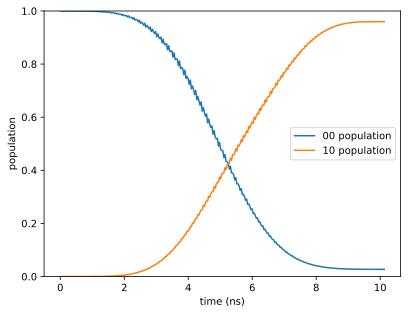

In [29]:
times = np.linspace(0, tau_p, 300)

options = qt.Options(rtol=1e-10, atol=1e-10, nsteps = 1000000000, store_states = True, store_final_state = True)

result = qt.sesolve(ham_list, zero_state, times, e_ops = observables, options = options, args = args)

plt.plot(times, result.expect[0], label='00 population')
plt.plot(times, result.expect[1], label = '10 population')
plt.ylim(0,1)
plt.legend()
plt.xlabel('time (ns)')
plt.ylabel('population')